In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load preprocessed data from 3_Preprocessing_Baseline
train_balanced = pd.read_csv('../3_Data_Preprocessing/preprocessing_data/train_balanced_baseline.csv')
df_test = pd.read_csv('../3_Data_Preprocessing/preprocessing_data/test_preprocessed_baseline.csv')

# Features and targets
final_features = ['AGEP', 'WKHP', 'SEX', 'DIS', 'CIT', 'Born_in_CA',
                  'SCHL_Tier', 'OCCP_grouped', 'CA_Region', 'RAC1P', 'year']

y_test = df_test['poverty_risk_score'].astype(int)

print(f'Train balanced: {train_balanced.shape}')
print(f'Test: {df_test.shape}')

Train balanced: (710046, 30)
Test: (304368, 30)


In [3]:

train_balanced['SCHL_Tier'] = train_balanced['SCHL_Tier'].astype(str)
df_test['SCHL_Tier'] = df_test['SCHL_Tier'].astype(str)

train_balanced['year'] = train_balanced['year'].astype(str)
df_test['year'] = df_test['year'].astype(str)

# 1. One-Hot Encoding

X_train = pd.get_dummies(train_balanced[final_features], drop_first=True)
X_test = pd.get_dummies(df_test[final_features], drop_first=True)

# 2. Align columns (Test might miss a category Train had)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 3. Scaling (Scale based on Train, apply to Test)
scaler = StandardScaler()
cont_feats = ['AGEP', 'WKHP']
X_train[cont_feats] = scaler.fit_transform(X_train[cont_feats])
X_test[cont_feats] = scaler.transform(X_test[cont_feats])

# 4. Multinomial Model

model = LogisticRegression(
   # multi_class='multinomial',
    solver='saga',
    max_iter=10000,
    penalty='l2',
    C=0.1,
    random_state=42,

)

model.fit(X_train, train_balanced['poverty_risk_score'].astype(int))

#  Final Evaln on 2024 Test Set
y_pred = model.predict(X_test)
print("=== Baseline Performance on 2024 ACS Test Set ===")
print(classification_report(y_test, y_pred))

=== Baseline Performance on 2024 ACS Test Set ===
              precision    recall  f1-score   support

           0       0.85      0.81      0.83    233793
           1       0.24      0.45      0.31     38456
           2       0.00      0.00      0.00     15534
           3       0.23      0.13      0.17     16585

    accuracy                           0.69    304368
   macro avg       0.33      0.35      0.33    304368
weighted avg       0.70      0.69      0.69    304368



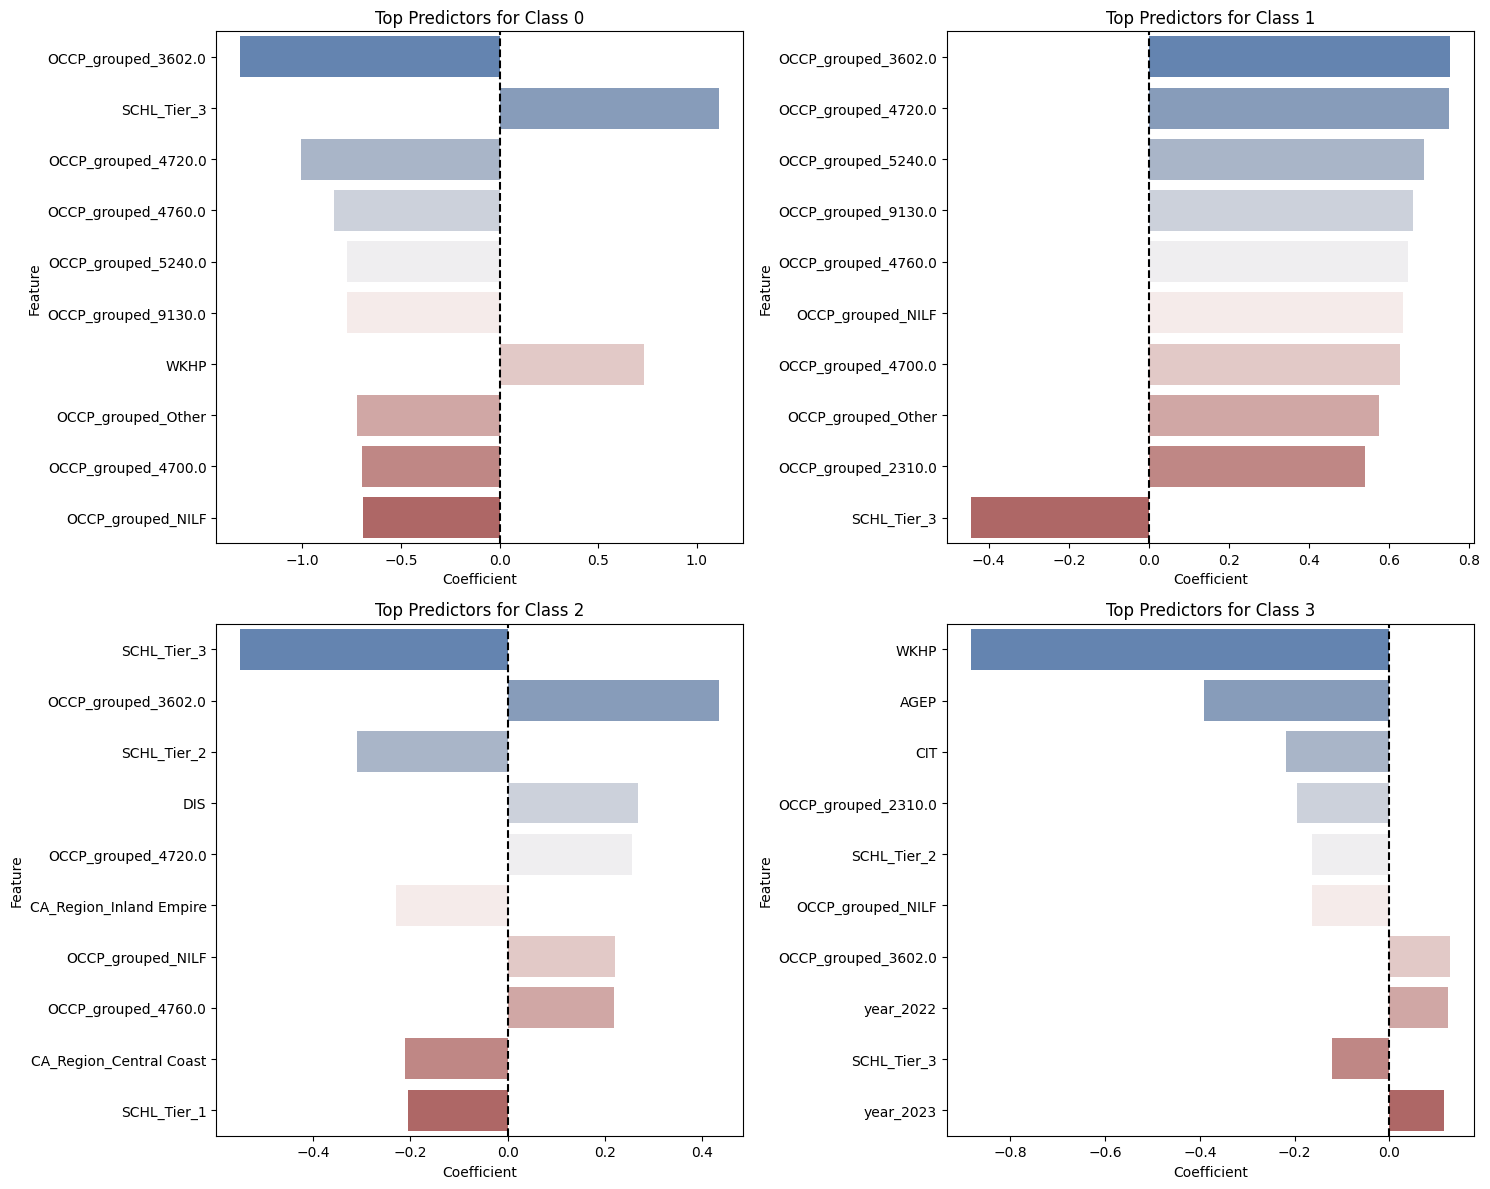

In [4]:
# Extract feature names from the One-Hot Encoded dataframe
feature_names = X_train.columns

# Get  coefficients (this is a matrix of [n_classes, n_features])
coefficients = model.coef_

#  a plotting function for the classes
def plot_top_coefficients(coeffs, names, class_labels, top_n=10):
    num_classes = len(class_labels)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for i in range(num_classes):
        # Create a DataFrame for this specific class
        coef_df = pd.DataFrame({
            'Feature': names,
            'Coefficient': coeffs[i]
        })

        # sorting by absolute value to see most influential (positive or negative)
        coef_df['abs_val'] = coef_df['Coefficient'].abs()
        top_feats = coef_df.sort_values(by='abs_val', ascending=False).head(top_n)


        sns.barplot(
            data=top_feats,
            y='Feature',
            x='Coefficient',
            ax=axes[i],
            palette='vlag'
        )
        axes[i].set_title(f"Top Predictors for Class {class_labels[i]}")
        axes[i].axvline(0, color='black', linestyle='--')

    plt.tight_layout()
    plt.show()


plot_top_coefficients(coefficients, feature_names, class_labels=[0, 1, 2, 3])


In [5]:
#WKHP (Hours Worked) = -0.80: This is a very strong negative correlation. It means that for every unit increase in hours worked, the log-odds of being in Deep Poverty drop significantly.
# category.SCHL_Tier_1 (HS Diploma/GED): Looking at coefficient list, the indices after the first few represent One-Hot encoded categories.
# notice that as the Tier number goes up 2=College, 3= Bachelors, the coefficients for Class 3 become more negative.

#For class 3:
#Negative (-) number: This feature makes you less likely to be in Deep Poverty.
#Positive (+) number: This feature makes you more likely to be in Deep Poverty (compared to the reference group).

In [6]:

classes = model.classes_
for i, class_label in enumerate(classes):
    print(f"--- Coefficients for class {class_label} (index {i}) ---")

    print(model.coef_[i])
    print(f"Intercept for class {class_label}: {model.intercept_[i]}\n")


--- Coefficients for class 0 (index 0) ---
[ 3.72275841e-01  7.33495781e-01 -1.33307851e-02 -4.02559973e-01
  4.11097424e-01  5.95915305e-02 -1.65148463e-04  3.58988112e-01
  6.24073533e-01  1.11527300e+00 -5.31004579e-01 -7.38328873e-02
 -1.31530402e+00 -3.99252886e-01 -6.95747957e-01 -1.00627708e+00
 -8.40018740e-01 -7.76044700e-01 -7.72085250e-01 -6.92588434e-01
 -7.22128068e-01  3.50702270e-01  1.62325331e-01  3.83858938e-01
  3.45275352e-01  3.62100282e-01  2.46340945e-01  9.93045274e-02
  8.27327676e-02  4.43728813e-02  5.67025971e-02]
Intercept for class 0: 0.4962675427320696

--- Coefficients for class 1 (index 1) ---
[ 0.06720842  0.24037763 -0.01819593  0.02773785 -0.08559589 -0.05326928
  0.0194653  -0.05317655 -0.15014127 -0.44512275  0.53895568  0.25270732
  0.75236721  0.33453361  0.62780055  0.75122739  0.64712261  0.68734436
  0.65883855  0.63559497  0.57524193 -0.07362136 -0.06291439 -0.10608343
 -0.13567623 -0.1963794  -0.05270205 -0.03997193 -0.08910447 -0.10295557
 